# Import packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model import Activity, Dictionary, SparseModel, sparsity_loss, dictionary_loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import importlib
import tensorflow as tf

# Loading data

In [2]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y, X = train['label'], train.loc[:, train.columns != 'label'] / 255

Split into training and testing sets for possible use later. Also, I wanted to check if the dicitinary works well with new data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X_train, X_test = X_train.values, X_test.values

In [7]:
X_train = X_train.reshape([X_train.shape[0], 28*28])
X_test = X_test.reshape([X_test.shape[0], 28*28])

# Goal
Mnist digit to dictionary and then back to digit

In [8]:
batch_size = 1680
epsilon = 1e-6
num_filters = 100
patches_per_img = 4
data_size = X_train.shape[0]
num_batches = data_size // batch_size
alpha = 0.01 #learning rate
sparsity_coef = 1 # sparsity coef
beta = .99 #The amount to retain for A and B
img_size = 28
dict_filter_size = img_size**2 //patches_per_img
activity_epochs = 300
epochs=30
num_layers=1

In [9]:
X_train = X_train.reshape([-1, dict_filter_size])
X_test = X_test.reshape([-1, dict_filter_size]) 

# ZCA Preprocessing

In [10]:
def zca(x):
    cov = np.cov(x)
    mean = x.mean()
    w, v = np.linalg.eig(cov)
    w_output = 1/(np.sqrt(w+1e-5))
    output = v @ np.diag(w_output) @ v.T @ (x - mean)
    return output

In [11]:
sparse_activity = Activity(batch_size=batch_size, units=num_filters, alpha=alpha, sparsity_coef=sparsity_coef)
sparse_dictionary = Dictionary(units=num_filters, dict_filter_size=dict_filter_size, beta=beta)
sparse_model = SparseModel(sparse_activity, sparse_dictionary, batch_size=batch_size, activity_epochs=activity_epochs, dict_filter_size=dict_filter_size, data_size=data_size, num_layers=num_layers)
sparse_model.compile(sparsity_loss, dictionary_loss)
datagen = ImageDataGenerator()
datagen.fit(X_train.reshape([-1, dict_filter_size, 1, 1]))
train_generator = datagen.flow(X_train.reshape([-1, dict_filter_size, 1, 1]), batch_size=batch_size)

In [12]:
sparse_model.fit(train_generator, epochs=epochs, batch_size=batch_size)

Epoch 1/30
67/67 [==============================] - 36s 282ms/step - dictionary loss: 0.0553 - sparsity loss: 6.5140e-05
Epoch 2/30
67/67 [==============================] - 19s 290ms/step - dictionary loss: 0.0445 - sparsity loss: 1.6690e-04
Epoch 3/30
67/67 [==============================] - 18s 271ms/step - dictionary loss: 0.0313 - sparsity loss: 2.5021e-04
Epoch 4/30
67/67 [==============================] - 19s 289ms/step - dictionary loss: 0.0285 - sparsity loss: 2.6574e-04
Epoch 5/30
67/67 [==============================] - 19s 290ms/step - dictionary loss: 0.0275 - sparsity loss: 2.7300e-04
Epoch 6/30
67/67 [==============================] - 20s 292ms/step - dictionary loss: 0.0262 - sparsity loss: 2.8285e-04
Epoch 7/30
67/67 [==============================] - 20s 292ms/step - dictionary loss: 0.0246 - sparsity loss: 2.9397e-04
Epoch 8/30
67/67 [==============================] - 19s 277ms/step - dictionary loss: 0.0228 - sparsity loss: 3.0820e-04
Epoch 9/30
67/67 [==============

# Filters

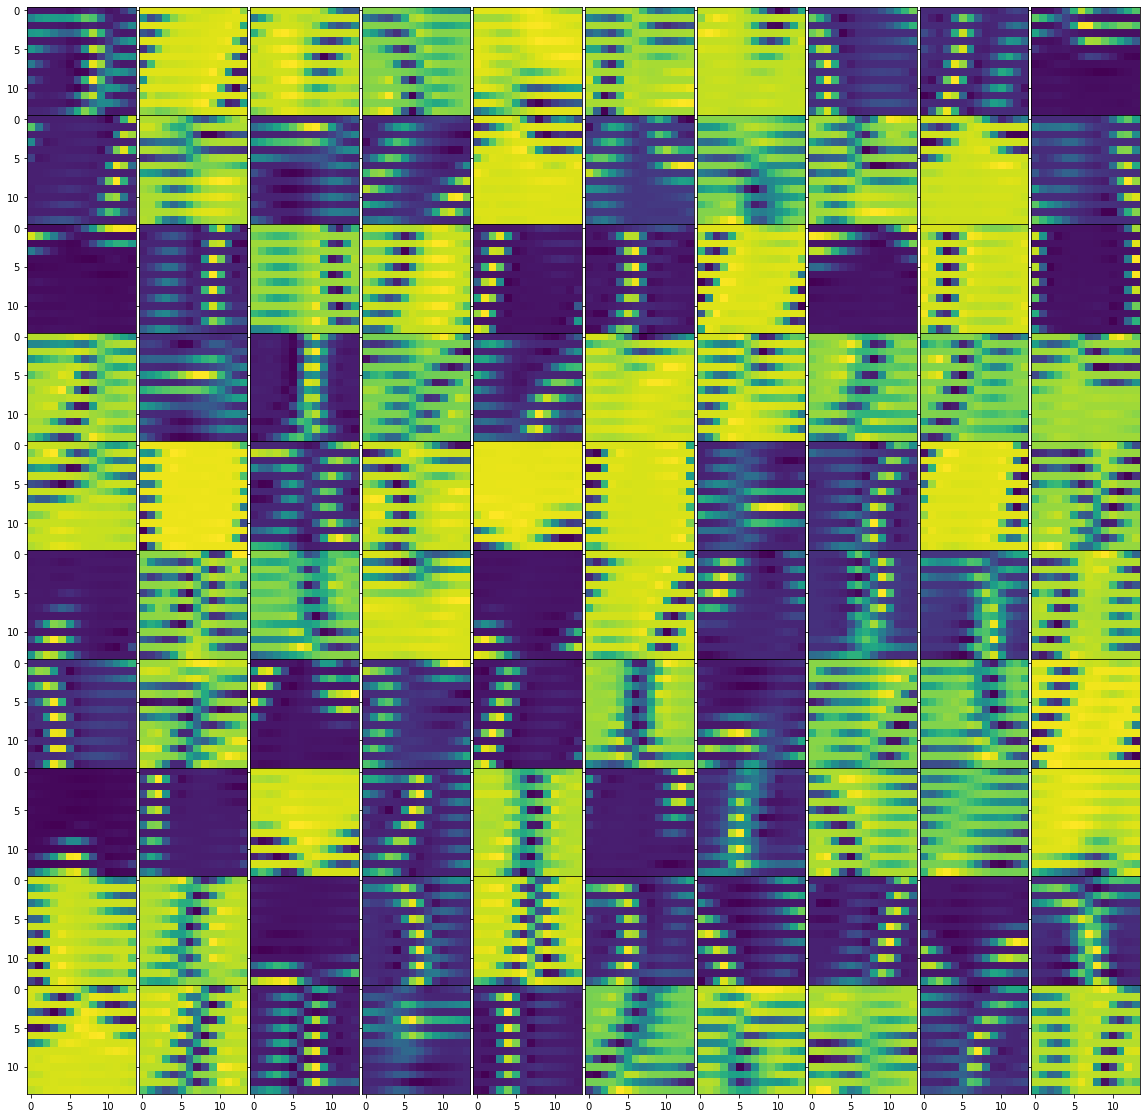

In [15]:
fig = plt.figure(figsize=(20, 20))
num_cols = 10
gs = fig.add_gridspec(num_filters //num_cols, num_cols, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_filters):
    axs[i // num_cols][i % num_cols].imshow(tf.reshape(sparse_model.dictionary.w[:, i], shape=[14,14]))
plt.show()

# Reconstructions

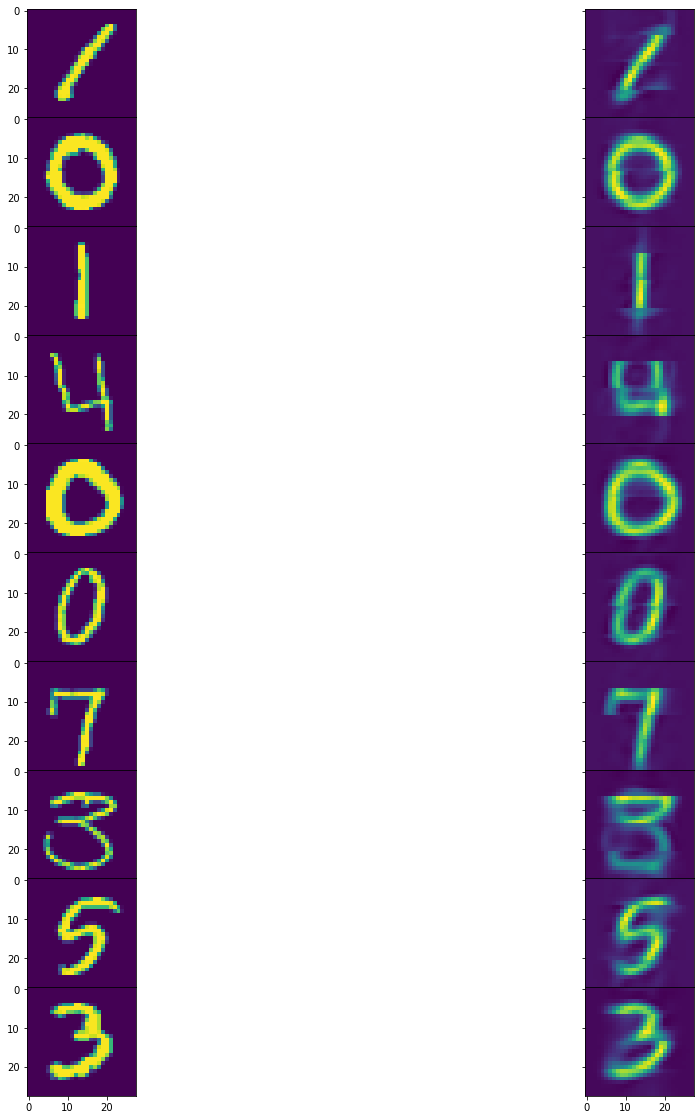

In [16]:
num_reconstructions = 10
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(num_reconstructions, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_reconstructions):
    axs[i][0].imshow(X.values[i].reshape([28, 28]))
    reconstructions = sparse_model.call(X.values[i].reshape([-1, dict_filter_size, 1, 1]))
    axs[i][1].imshow(tf.reshape(reconstructions, [28, 28]))
plt.show()

# Observations
- If not enough filters, the model chooses to decrease sparsity loss while barely decreasing dictionary loss

## ZCA whitening should increase performance